#### Imports & Downloads

In [102]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgboost
from sklearn.svm import LinearSVC

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score
import vectorize_functions

from sklearn.metrics import mean_squared_error
import time
import optuna

from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances
from typing import Tuple
from sklearn.metrics import log_loss
from optuna.samplers import TPESampler

### Einladen der vektorisierten Daten - Word2Vec

In [29]:
X_train, X_test, y_train, y_test = vectorize_functions.vectorize_w2v()

In [30]:
positive = np.count_nonzero(y_train == 1)
negative = np.count_nonzero(y_train == 0)
print("Train")
print("- Positive:", positive)
print("- Negative:", negative)
print("- Verhältnis:", negative / positive)

positive = np.count_nonzero(y_test == 1)
negative = np.count_nonzero(y_test == 0)
print("Test")
print("- Positive:", positive)
print("- Negative:", negative)
print("- Verhältnis:", negative / positive)

Train
- Positive: 1270
- Negative: 18084
- Verhältnis: 14.239370078740157
Test
- Positive: 541
- Negative: 7754
- Verhältnis: 14.33271719038817


In [31]:
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)

print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (19354, 300)
y_train shape (19354,)
X_test shape (8295, 300)
y_test shape (8295,)


### 2. Ensemble Models

In [107]:
evaluation = pd.DataFrame(
    columns=["model", "variant", "train_acc", "train_prec", "train_rec", "train_f1", "test_acc", "test_prec",
             "test_rec", "test_f1"])

In [33]:
def add_to_eval_df(model, model_name, variant, x_data_train, y_data_train, x_data_test, y_data_test):
    train_acc = model.score(x_data_train, y_data_train)
    train_precision = precision_score(y_data_train, model.predict(x_data_train))
    train_recall = recall_score(y_data_train, model.predict(x_data_train))
    train_f1 = f1_score(y_data_train, model.predict(x_data_train))

    test_acc = model.score(x_data_test, y_data_test)
    test_precision = precision_score(y_data_test, model.predict(x_data_test))
    test_recall = recall_score(y_data_test, model.predict(x_data_test))
    test_f1 = f1_score(y_data_test, model.predict(x_data_test))

    evaluation.loc[len(evaluation.index)] = [model_name, variant, train_acc, train_precision, train_recall, train_f1,
                                             test_acc, test_precision, test_recall, test_f1]

In [34]:
def evaluate_model(model, x_test, y_test, sampling_method):
    pred = model.predict(x_test)
    accscore = metrics.accuracy_score(pred, y_test)

    print(f'{sampling_method} model accuracy for classification is =', str('{:04.2f}'.format(accscore * 100)) + '%')
    print('------------------------------------------------')
    print('Confusion Matrix:')
    print(pd.DataFrame(confusion_matrix(y_test, pred)))
    print('------------------------------------------------')
    print('Classification Report:')
    print(classification_report(y_test, pred))

    probs = model.predict_proba(x_test)
    preds = probs[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


#### 2.1 Bagging

##### 2.1.1 RandomForest

###### RandomForest no tuning

In [35]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

none model accuracy for classification is = 94.37%
------------------------------------------------
Confusion Matrix:
      0    1
0  7728   26
1   441  100
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      7754
           1       0.79      0.18      0.30       541

    accuracy                           0.94      8295
   macro avg       0.87      0.59      0.64      8295
weighted avg       0.94      0.94      0.93      8295



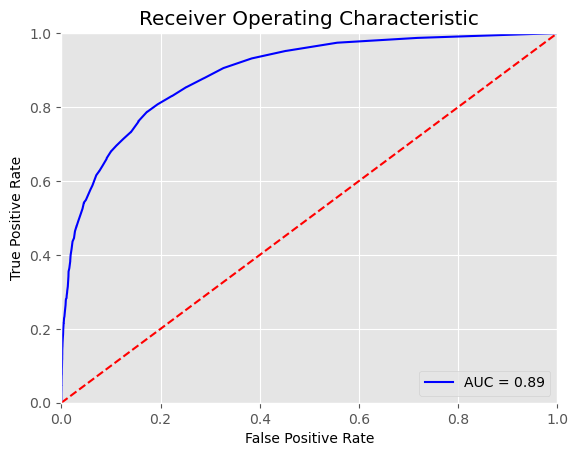

In [108]:
evaluate_model(rf, X_test, y_test, "none")
add_to_eval_df(rf, "RandomForestClassifier", "clean", X_train, y_train, X_test, y_test)

In [37]:
cv = cross_val_score(rf, X_train, y_train, cv=10, scoring='f1', verbose=10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ................................ score: (test=0.366) total time=  15.3s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.3s remaining:    0.0s


[CV] END ................................ score: (test=0.373) total time=   5.4s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   20.9s remaining:    0.0s


[CV] END ................................ score: (test=0.313) total time=   5.3s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.3s remaining:    0.0s


[CV] END ................................ score: (test=0.327) total time=   4.6s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   31.0s remaining:    0.0s


[CV] END ................................ score: (test=0.333) total time=   4.6s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   35.7s remaining:    0.0s


[CV] END ................................ score: (test=0.286) total time=   4.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   40.4s remaining:    0.0s


[CV] END ................................ score: (test=0.327) total time=   4.9s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   45.5s remaining:    0.0s


[CV] END ................................ score: (test=0.259) total time=   4.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   50.3s remaining:    0.0s


[CV] END ................................ score: (test=0.323) total time=   4.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   55.1s remaining:    0.0s


[CV] END ................................ score: (test=0.352) total time=   4.6s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   59.8s finished


In [38]:
np.mean(cv)

0.32594920930845156

###### RandomForest tuning (GridSearchCV)

In [39]:
# todo

###### RandomForest tuning (RandomizedSearchCV)

In [40]:
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [9, 11, 13],
}

In [41]:
random_search = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1),
                                   param_grid,
                                   scoring='f1',
                                   verbose=10)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START max_depth=6, max_features=sqrt, max_leaf_nodes=13, n_estimators=150
[CV 1/5; 1/10] END max_depth=6, max_features=sqrt, max_leaf_nodes=13, n_estimators=150;, score=0.150 total time=   2.5s
[CV 2/5; 1/10] START max_depth=6, max_features=sqrt, max_leaf_nodes=13, n_estimators=150
[CV 2/5; 1/10] END max_depth=6, max_features=sqrt, max_leaf_nodes=13, n_estimators=150;, score=0.108 total time=   2.3s
[CV 3/5; 1/10] START max_depth=6, max_features=sqrt, max_leaf_nodes=13, n_estimators=150
[CV 3/5; 1/10] END max_depth=6, max_features=sqrt, max_leaf_nodes=13, n_estimators=150;, score=0.171 total time=   2.3s
[CV 4/5; 1/10] START max_depth=6, max_features=sqrt, max_leaf_nodes=13, n_estimators=150
[CV 4/5; 1/10] END max_depth=6, max_features=sqrt, max_leaf_nodes=13, n_estimators=150;, score=0.129 total time=   2.3s
[CV 5/5; 1/10] START max_depth=6, max_features=sqrt, max_leaf_nodes=13, n_estimators=150
[CV 5/5; 1/10]

RandomizedSearchCV(estimator=RandomForestClassifier(n_jobs=-1),
                   param_distributions={'max_depth': [3, 6, 9],
                                        'max_features': ['sqrt', 'log2', None],
                                        'max_leaf_nodes': [9, 11, 13],
                                        'n_estimators': [100, 150, 200, 250]},
                   scoring='f1', verbose=10)

In [44]:
print(random_search.best_estimator_)

RandomForestClassifier(max_depth=9, max_features=None, max_leaf_nodes=13,
                       n_jobs=-1)


In [45]:
rf_tuned = RandomForestClassifier(**random_search.best_params_)
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, max_features=None, max_leaf_nodes=13)

none model accuracy for classification is = 94.19%
------------------------------------------------
Confusion Matrix:
      0   1
0  7733  21
1   461  80
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      7754
           1       0.79      0.15      0.25       541

    accuracy                           0.94      8295
   macro avg       0.87      0.57      0.61      8295
weighted avg       0.93      0.94      0.92      8295



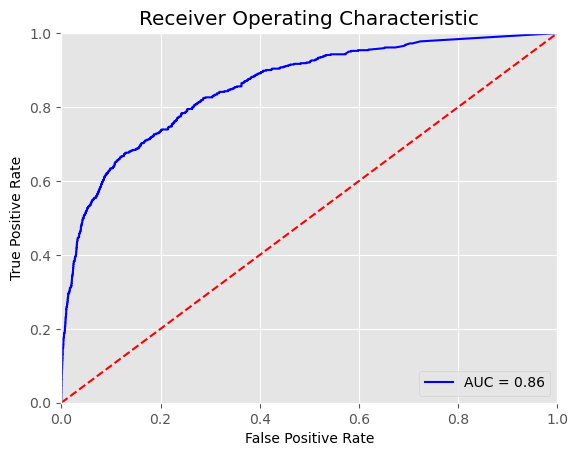

In [109]:
evaluate_model(rf_tuned, X_test, y_test, "none")
add_to_eval_df(rf_tuned, "RandomForestClassifier-tuned-rand", "clean", X_train, y_train, X_test, y_test)

###### RandomForest tuning (optuna)
https://gist.github.com/shamilnabiyev/c1b6e23444a949bc45243eab445a3806

In [47]:
def objective_rf(trial):
    n_estimators = trial.suggest_int(name="n_estimators", low=100, high=500, step=50)
    max_depth = trial.suggest_int(name="max_depth", low=10, high=150, step=5)
    min_samples_split = trial.suggest_int(name="min_samples_split", low=2, high=10, step=2)
    min_samples_leaf = trial.suggest_int(name="min_samples_leaf", low=1, high=4, step=1)

    params = {
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf
    }
    model = RandomForestClassifier(random_state=42, **params)

    cv_score = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=5, scoring='f1')
    mean_cv_accuracy = cv_score.mean()
    return mean_cv_accuracy

In [ ]:
sampler = TPESampler(seed=42)
pruner = optuna.pruners.MedianPruner(n_warmup_steps=10)
study_rf = optuna.create_study(sampler=sampler, pruner=pruner, direction="maximize")
study_rf.optimize(objective_rf, n_trials=50)

[I 2024-11-24 13:57:38,736] A new study created in memory with name: no-name-43a5dfa2-a119-479e-b658-2866675cbbc7
[I 2024-11-24 13:59:03,762] Trial 0 finished with value: 0.31466471391165246 and parameters: {'n_estimators': 250, 'max_depth': 145, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.31466471391165246.
[I 2024-11-24 13:59:49,316] Trial 1 finished with value: 0.3063804152538467 and parameters: {'n_estimators': 150, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.31466471391165246.
[I 2024-11-24 14:01:32,242] Trial 2 finished with value: 0.30793445391576235 and parameters: {'n_estimators': 350, 'max_depth': 110, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.31466471391165246.
[I 2024-11-24 14:03:54,444] Trial 3 finished with value: 0.32980759528579195 and parameters: {'n_estimators': 450, 'max_depth': 40, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 3 wi

Number of finished trials: 35
Best trial:
  Value: 0.33697164443769506
  Params: 
    n_estimators: 450
    max_depth: 55
    min_samples_split: 4
    min_samples_leaf: 1


C:\Users\admin\AppData\Local\Temp\ipykernel_24188\2334329262.py:12: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study_rf)
C:\Users\admin\AppData\Local\Temp\ipykernel_24188\2334329262.py:13: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study_rf)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

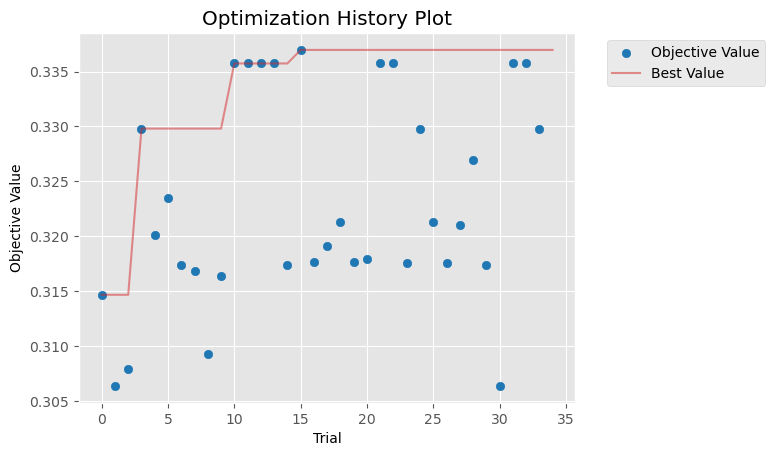

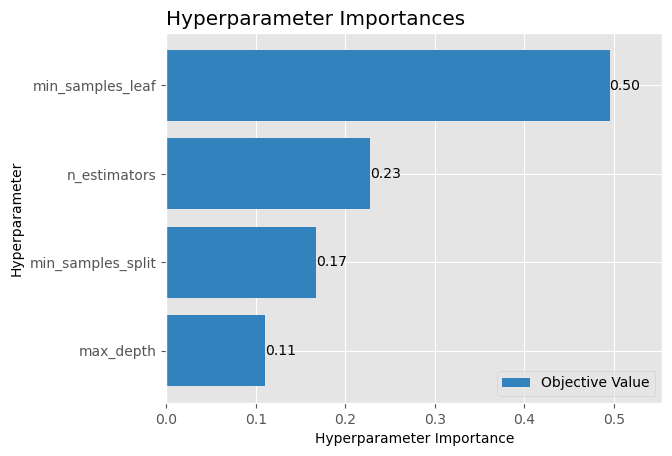

In [50]:
print("Number of finished trials: {}".format(len(study_rf.trials)))

print("Best trial:")
trial = study_rf.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

plot_optimization_history(study_rf)
plot_param_importances(study_rf)

none model accuracy for classification is = 94.37%
------------------------------------------------
Confusion Matrix:
      0    1
0  7723   31
1   436  105
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      7754
           1       0.77      0.19      0.31       541

    accuracy                           0.94      8295
   macro avg       0.86      0.60      0.64      8295
weighted avg       0.94      0.94      0.93      8295



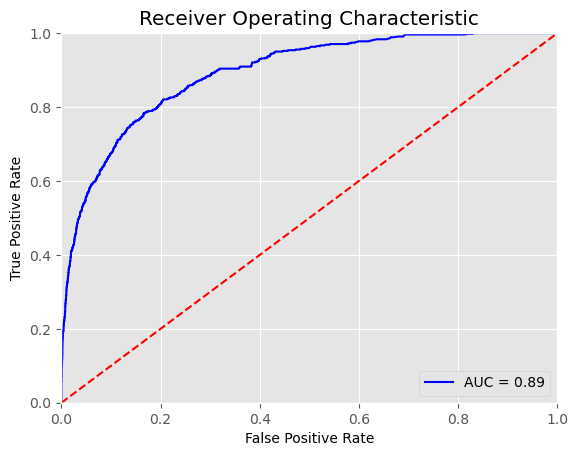

In [51]:
rf_tuned_optuna = RandomForestClassifier(**study_rf.best_trial.params)
rf_tuned_optuna.fit(X_train, y_train)

none model accuracy for classification is = 94.37%
------------------------------------------------
Confusion Matrix:
      0    1
0  7723   31
1   436  105
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      7754
           1       0.77      0.19      0.31       541

    accuracy                           0.94      8295
   macro avg       0.86      0.60      0.64      8295
weighted avg       0.94      0.94      0.93      8295



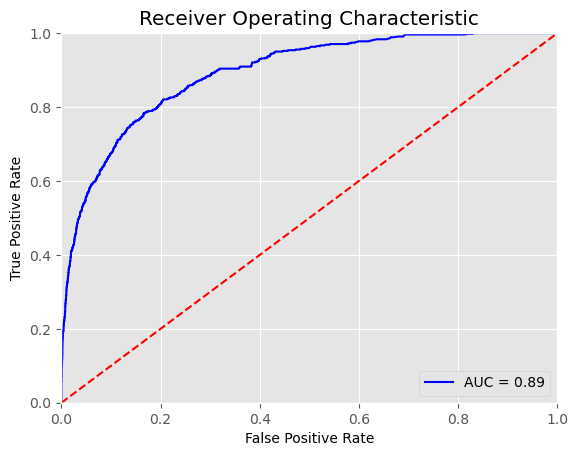

In [110]:
evaluate_model(rf_tuned_optuna, X_test, y_test, "none")
add_to_eval_df(rf_tuned_optuna, "RandomForest-tuned-optuna", "clean", X_train, y_train, X_test, y_test)

##### 2.1.2 BalancedRandomForest untuned

###### BalancedRandomForest no tuning

In [52]:
brf = BalancedRandomForestClassifier(n_jobs=-1)
brf.fit(X_train, y_train)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

BalancedRandomForestClassifier(n_jobs=-1)

none model accuracy for classification is = 84.05%
------------------------------------------------
Confusion Matrix:
      0     1
0  6549  1205
1   118   423
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.84      0.91      7754
           1       0.26      0.78      0.39       541

    accuracy                           0.84      8295
   macro avg       0.62      0.81      0.65      8295
weighted avg       0.94      0.84      0.87      8295



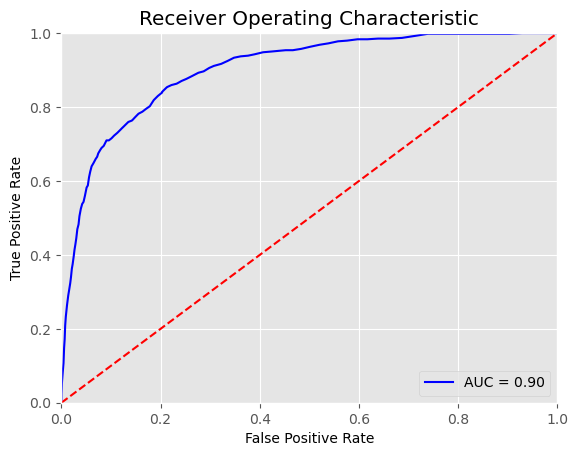

In [119]:
evaluate_model(brf, X_test, y_test, "none")
add_to_eval_df(brf, "BalancedRandomForestClassifier", "clean", X_train, y_train, X_test, y_test)

In [54]:
cv = cross_val_score(brf, X_train, y_train, cv=10, scoring='f1', verbose=10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] START .....................................................................
[CV] END ................................ score: (test=0.414) total time=   8.6s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.6s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.429) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.4s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.399) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.5s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.390) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   11.4s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.431) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.5s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.416) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   13.7s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.393) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   14.8s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.410) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   15.9s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.419) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   17.0s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.382) total time=   0.9s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.0s finished


In [55]:
np.mean(cv)

0.4083028765334027

###### BalancedRandomForest tuning (RandomizedSearchCV)

In [56]:
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [9, 11, 13],
}

In [57]:
random_search = RandomizedSearchCV(BalancedRandomForestClassifier(n_jobs=-1),
                                   param_grid,
                                   scoring='f1',
                                   verbose=0)
random_search.fit(X_train, y_train)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: 

RandomizedSearchCV(estimator=BalancedRandomForestClassifier(n_jobs=-1),
                   param_distributions={'max_depth': [3, 6, 9],
                                        'max_features': ['sqrt', 'log2', None],
                                        'max_leaf_nodes': [9, 11, 13],
                                        'n_estimators': [100, 150, 200, 250]},
                   scoring='f1')

In [58]:
brf_tuned = BalancedRandomForestClassifier(**random_search.best_params_, verbose=0)
brf_tuned.fit(X_train, y_train)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklear

BalancedRandomForestClassifier(max_depth=6, max_features='log2',
                               max_leaf_nodes=11)

none model accuracy for classification is = 82.29%
------------------------------------------------
Confusion Matrix:
      0     1
0  6401  1353
1   116   425
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.83      0.90      7754
           1       0.24      0.79      0.37       541

    accuracy                           0.82      8295
   macro avg       0.61      0.81      0.63      8295
weighted avg       0.93      0.82      0.86      8295



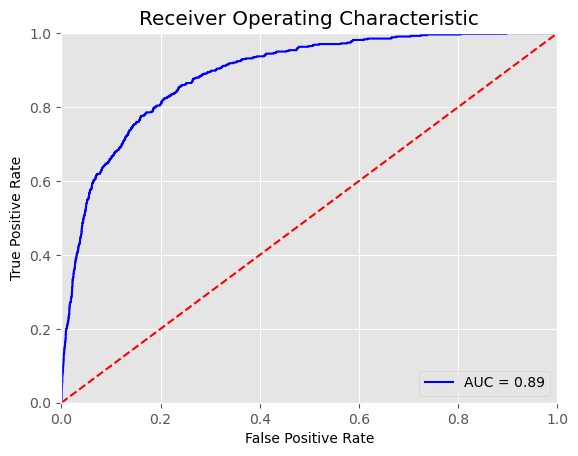

In [120]:
evaluate_model(brf_tuned, X_test, y_test, "none")
add_to_eval_df(brf_tuned, "BalancedRandomForestClassifier-tuned", "clean", X_train, y_train, X_test, y_test)

#### 2.2 Boosting

##### 2.2.1 XGBClassifier

In [60]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

none model accuracy for classification is = 94.74%
------------------------------------------------
Confusion Matrix:
      0    1
0  7669   85
1   351  190
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      7754
           1       0.69      0.35      0.47       541

    accuracy                           0.95      8295
   macro avg       0.82      0.67      0.72      8295
weighted avg       0.94      0.95      0.94      8295



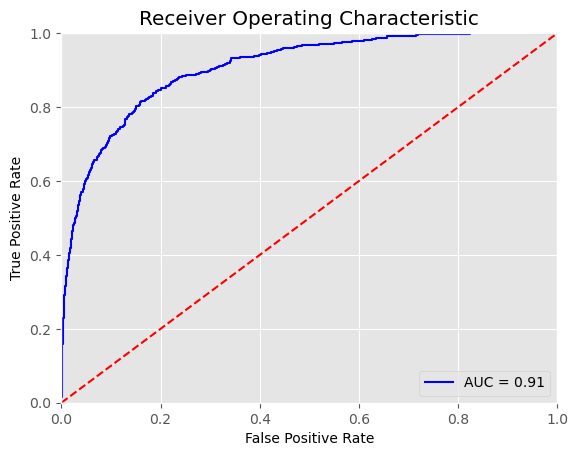

In [118]:
evaluate_model(xgb, X_test, y_test, "none")
add_to_eval_df(xgb, "XGBClassifier", "clean", X_train, y_train, X_test, y_test)

###### XGBClassifier tuning (GridSearchCV)
https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

Tuning mit GridSearchCV dauert bei großer param-Liste sehr lange, daher einzelne Schritte mit jeweils nur 1 bis max. 2 params

auskommentierte Werte stammen aus TF-IDF GridSearch


In [62]:
param_test = {
    'learning_rate': [0.1, 0.01, 0.001],
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.32039688186494825, {'learning_rate': 0.1})

none model accuracy for classification is = 94.82%
------------------------------------------------
Confusion Matrix:
      0    1
0  7684   70
1   360  181
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      7754
           1       0.72      0.33      0.46       541

    accuracy                           0.95      8295
   macro avg       0.84      0.66      0.71      8295
weighted avg       0.94      0.95      0.94      8295



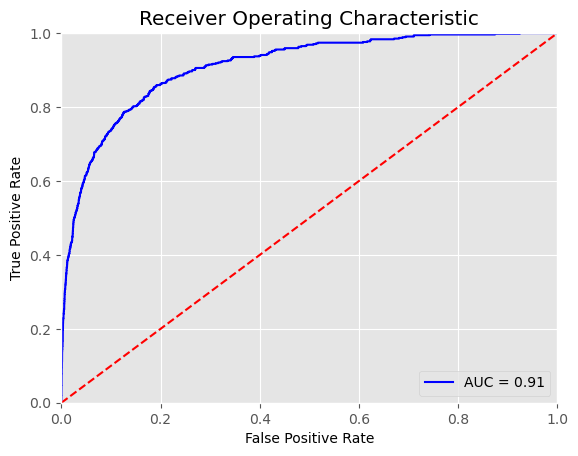

In [63]:
xgb_test = XGBClassifier(learning_rate=0.1)
xgb_test.fit(X_train, y_train)
evaluate_model(xgb_test, X_test, y_test, "none")

In [64]:
param_test = {
    'n_estimators': range(100, 250, 50),
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.37817637241282653, {'n_estimators': 200})

none model accuracy for classification is = 95.03%
------------------------------------------------
Confusion Matrix:
      0    1
0  7698   56
1   356  185
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      7754
           1       0.77      0.34      0.47       541

    accuracy                           0.95      8295
   macro avg       0.86      0.67      0.72      8295
weighted avg       0.94      0.95      0.94      8295



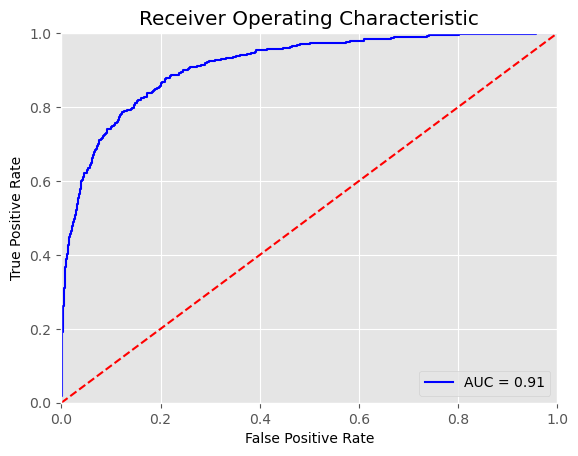

In [65]:
xgb_test = XGBClassifier(learning_rate=0.1, n_estimators=200)
xgb_test.fit(X_train, y_train)
evaluate_model(xgb_test, X_test, y_test, "none")

In [66]:
param_test = {
    'max_depth': range(5, 13, 2),
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.4298347587940351, {'max_depth': 11})

none model accuracy for classification is = 94.76%
------------------------------------------------
Confusion Matrix:
      0    1
0  7689   65
1   370  171
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7754
           1       0.72      0.32      0.44       541

    accuracy                           0.95      8295
   macro avg       0.84      0.65      0.71      8295
weighted avg       0.94      0.95      0.94      8295



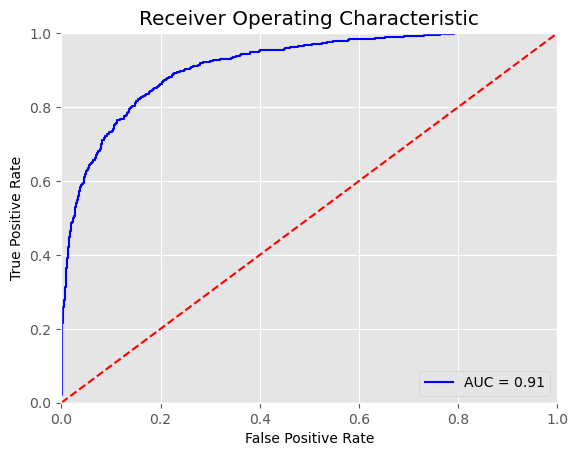

In [67]:
xgb_test = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=11)
xgb_test.fit(X_train, y_train)
evaluate_model(xgb_test, X_test, y_test, "none")

In [68]:
param_test = {
    'subsample': [0.5, 0.7, 1]
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=11,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.4406213750099548, {'subsample': 0.7})

none model accuracy for classification is = 94.89%
------------------------------------------------
Confusion Matrix:
      0    1
0  7689   65
1   359  182
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      7754
           1       0.74      0.34      0.46       541

    accuracy                           0.95      8295
   macro avg       0.85      0.66      0.72      8295
weighted avg       0.94      0.95      0.94      8295



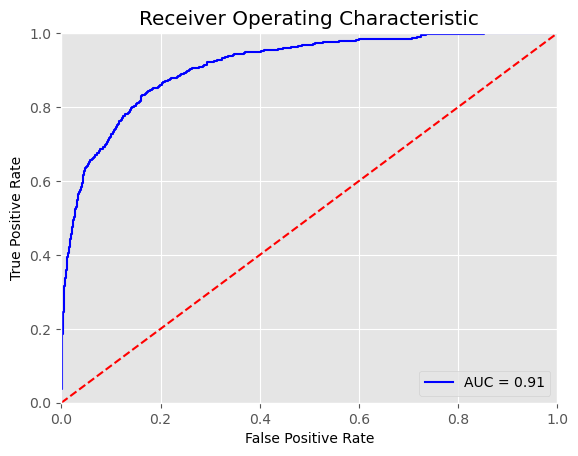

In [69]:
xgb_test = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=11, subsample=0.7)
xgb_test.fit(X_train, y_train)
evaluate_model(xgb_test, X_test, y_test, "none")

In [70]:
param_test = {
    'min_child_weight': range(1, 6, 2),
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=11,
    subsample=0.7,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.4406213750099548, {'min_child_weight': 1}) <== kein Einfluss auf Modellperformance

In [71]:
param_test = {
    'gamma': [i / 10.0 for i in range(0, 5)],
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=11,
    subsample=0.7,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.4406213750099548, {'gamma': 0.0}) <== kein Einfluss auf Modellperformance

In [72]:
param_test = {
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=11,
    subsample=0.7,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

gsearch.fit(X_train, y_train)
gsearch.best_score_, gsearch.best_params_

# (0.44114103318625436, {'reg_alpha': 0.01})

Fitting 5 folds for each of 5 candidates, totalling 25 fits


(0.4508663724036147, {'reg_alpha': 1})

In [73]:
param_test = {
    'reg_alpha': [0.005, 0.01, 0.015, 0.02, 0.025]
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=11,
    subsample=0.7,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

gsearch.fit(X_train, y_train)
gsearch.best_score_, gsearch.best_params_

# # (0.44114103318625436, {'reg_alpha': 0.01})

Fitting 5 folds for each of 5 candidates, totalling 25 fits


(0.45502798275680434, {'reg_alpha': 0.02})

In [74]:
xgb_tuned_grid = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=11, subsample=0.7, reg_alpha=0.01)
xgb_tuned_grid.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

none model accuracy for classification is = 94.85%
------------------------------------------------
Confusion Matrix:
      0    1
0  7689   65
1   362  179
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      7754
           1       0.73      0.33      0.46       541

    accuracy                           0.95      8295
   macro avg       0.84      0.66      0.71      8295
weighted avg       0.94      0.95      0.94      8295



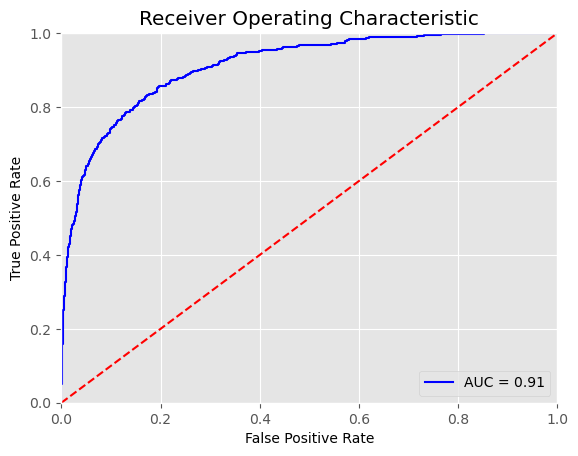

In [111]:
evaluate_model(xgb_tuned_grid, X_test, y_test, "none")
add_to_eval_df(xgb_tuned_grid, "XGBClassifier-tuned-grid", "clean", X_train, y_train, X_test, y_test)

###### XGBClassifier tuning (RandomizedSearchCV)
Vergleich Modellperformance zwischen GridSearchCV <-> RandomizedSearchCV

In [76]:
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': range(100, 250, 50),
    'max_depth': range(5, 13, 2),
    'subsample': [0.5, 0.7, 1],
    'min_child_weight': range(1, 6, 2),
    'gamma': [i / 10.0 for i in range(0, 5)],
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100],
}

In [77]:
rsearch = RandomizedSearchCV(XGBClassifier(n_jobs=-1),
                             param_grid,
                             scoring='f1',
                             verbose=1,
                             cv=5,
                             )

In [78]:
rsearch.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=-1,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   param_distributions={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.1, 0.01, 0.001],
                                        'max_depth': range(5, 13, 2),
                                        'min_child_weight': range(1, 6, 2),
                                        'n_estimators': range(100, 250, 50),
                                        'reg_alpha': [1e-05, 0.01, 0.1, 1, 100],
                                        'subsample': [0.5, 0.7, 1]},
                   scoring='f1', verbose=1)

In [79]:
rsearch.best_score_, rsearch.best_params_

(0.44367344272738907,
 {'subsample': 0.5,
  'reg_alpha': 1,
  'n_estimators': 150,
  'min_child_weight': 1,
  'max_depth': 7,
  'learning_rate': 0.1,
  'gamma': 0.4})

In [80]:
xgb_tuned_rand = XGBClassifier(**rsearch.best_params_, n_jobs=-1)
xgb_tuned_rand.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

none model accuracy for classification is = 94.89%
------------------------------------------------
Confusion Matrix:
      0    1
0  7683   71
1   353  188
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      7754
           1       0.73      0.35      0.47       541

    accuracy                           0.95      8295
   macro avg       0.84      0.67      0.72      8295
weighted avg       0.94      0.95      0.94      8295



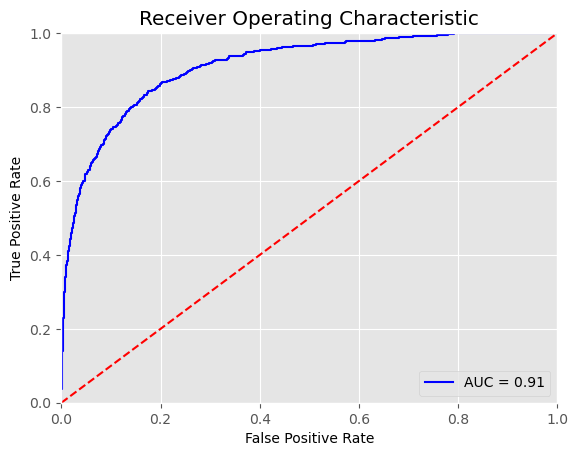

In [112]:
evaluate_model(xgb_tuned_rand, X_test, y_test, "none")
add_to_eval_df(xgb_tuned_rand, "XGBClassifier-tuned-rand", "clean", X_train, y_train, X_test, y_test)

###### XGBClassifier tuning (optuna)
https://randomrealizations.com/posts/xgboost-parameter-tuning-with-optuna/
https://www.kaggle.com/code/rzatemizel/optuna-xgboostcv-integration-with-pruning#Intro

In [103]:
def balancedlogloss(predt: np.ndarray, dtrain: xgboost.DMatrix) -> Tuple[str, float]:
    ''' balanced log loss metric.'''
    y = dtrain.get_label()
    target_mean = y.mean()
    w0 = 1 / (1 - target_mean)
    w1 = 1 / target_mean
    sample_weight = [w0 if y == 0 else w1 for y in y]
    loss = log_loss(y, predt, eps=1e-15, sample_weight=sample_weight)

    return 'balancedlogloss', loss

def objective(trial):
    dtrain = xgboost.DMatrix(X_train, label=y_train)

    param = {

        "verbosity": 0,
        "objective": "binary:logistic",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 0.8),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 0.8),
        'scale_pos_weight': 509 / 108,
        'random_state': 42,
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 16)
        param["eta"] = trial.suggest_float("eta", 1e-3, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "test-balancedlogloss")
    history = xgboost.cv(param,
                     dtrain,
                     stratified=True,
                     nfold=5,
                     num_boost_round=10000,
                     early_stopping_rounds=50,
                     custom_metric=balancedlogloss,
                     seed=42,
                     callbacks=[pruning_callback])

    mean_balancedlogloss = history["test-balancedlogloss-mean"].values[-1]
    trial.set_user_attr("n_estimators", len(history))
    return mean_balancedlogloss


In [104]:
sampler = TPESampler(seed=42)
pruner = optuna.pruners.MedianPruner(n_warmup_steps=10)
study = optuna.create_study(sampler=sampler, pruner=pruner, direction="minimize")
study.optimize(objective, n_trials=5)

[I 2024-11-24 19:29:51,160] A new study created in memory with name: no-name-bd5bb3b2-12da-46ea-8ee9-51d0eae59f86
[I 2024-11-24 19:34:48,005] Trial 0 finished with value: 0.4570124 and parameters: {'booster': 'gblinear', 'lambda': 0.0006155564318973012, 'alpha': 1.77071686435378e-07, 'subsample': 0.2935967122017216, 'colsample_bytree': 0.23485016730091968}. Best is trial 0 with value: 0.4570124.
[I 2024-11-24 19:53:15,938] Trial 1 finished with value: 0.4640338 and parameters: {'booster': 'gbtree', 'lambda': 1.4610865886287176e-08, 'alpha': 0.574485163632042, 'subsample': 0.6994655844802531, 'colsample_bytree': 0.3274034664069657, 'max_depth': 3, 'eta': 0.0035498788321965025, 'gamma': 2.716051144654844e-06, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.4570124.
[I 2024-11-24 19:58:11,548] Trial 2 finished with value: 0.4465438 and parameters: {'booster': 'gblinear', 'lambda': 2.1734877073417355e-06, 'alpha': 8.528933855762793e-06, 'subsample': 0.4736419905302216, 'colsampl

Number of finished trials: 5
Best trial:
  Value: 0.4465438
  Params: 
    booster: gblinear
    lambda: 2.1734877073417355e-06
    alpha: 8.528933855762793e-06
    subsample: 0.4736419905302216
    colsample_bytree: 0.6711055768358083


C:\Users\admin\AppData\Local\Temp\ipykernel_24188\993762437.py:13: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)
C:\Users\admin\AppData\Local\Temp\ipykernel_24188\993762437.py:14: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

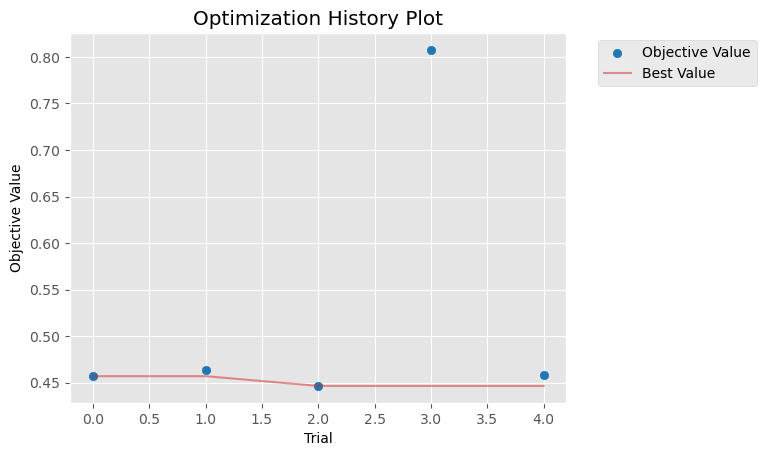

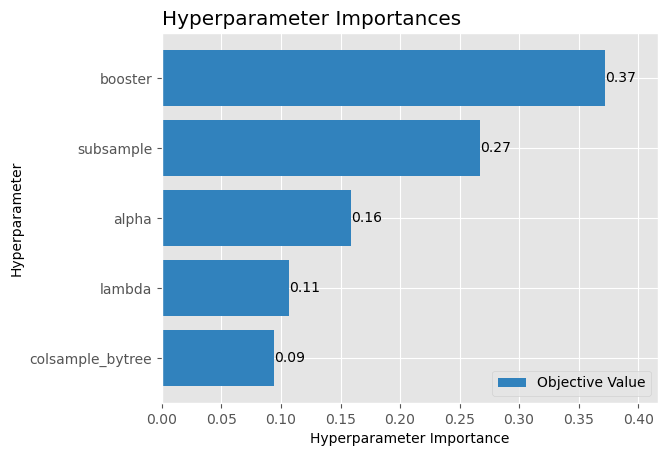

In [105]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# print("  Number of estimators: {}".format(trial.user_attrs["n_estimators"]))

plot_optimization_history(study)
plot_param_importances(study)

none model accuracy for classification is = 94.24%
------------------------------------------------
Confusion Matrix:
      0    1
0  7690   64
1   414  127
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7754
           1       0.66      0.23      0.35       541

    accuracy                           0.94      8295
   macro avg       0.81      0.61      0.66      8295
weighted avg       0.93      0.94      0.93      8295



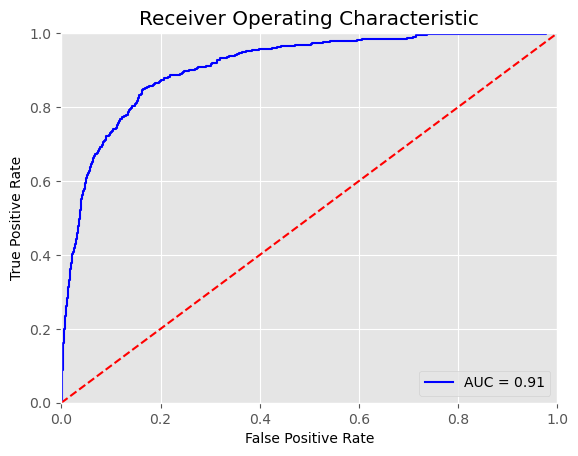

ValueError: cannot set a row with mismatched columns

In [106]:
xgb_tuned_optuna = XGBClassifier(**study.best_trial.params)
xgb_tuned_optuna.fit(X_train, y_train)
evaluate_model(xgb_tuned_optuna, X_test, y_test, "none")
add_to_eval_df(xgb_tuned_optuna, "XGBClassifier-tuned-optuna", "clean", X_train, y_train, X_test, y_test)

##### 2.2.1 CatBoostClassifier

In [89]:
cat = CatBoostClassifier(iterations=100,
                         depth=5,
                         learning_rate=0.1,
                         loss_function='Logloss',
                         verbose=True)
cat.fit(X_train, y_train)

0:	learn: 0.5744770	total: 259ms	remaining: 25.6s
1:	learn: 0.4724114	total: 402ms	remaining: 19.7s
2:	learn: 0.3937063	total: 484ms	remaining: 15.7s
3:	learn: 0.3365071	total: 534ms	remaining: 12.8s
4:	learn: 0.2961040	total: 566ms	remaining: 10.8s
5:	learn: 0.2653011	total: 591ms	remaining: 9.26s
6:	learn: 0.2445899	total: 615ms	remaining: 8.18s
7:	learn: 0.2297653	total: 644ms	remaining: 7.41s
8:	learn: 0.2180548	total: 669ms	remaining: 6.76s
9:	learn: 0.2085117	total: 694ms	remaining: 6.25s
10:	learn: 0.1990982	total: 720ms	remaining: 5.82s
11:	learn: 0.1926973	total: 744ms	remaining: 5.46s
12:	learn: 0.1862566	total: 769ms	remaining: 5.15s
13:	learn: 0.1822606	total: 794ms	remaining: 4.88s
14:	learn: 0.1785673	total: 819ms	remaining: 4.64s
15:	learn: 0.1750937	total: 844ms	remaining: 4.43s
16:	learn: 0.1718750	total: 868ms	remaining: 4.24s
17:	learn: 0.1689068	total: 890ms	remaining: 4.06s
18:	learn: 0.1669718	total: 912ms	remaining: 3.89s
19:	learn: 0.1657305	total: 935ms	remaini

none model accuracy for classification is = 94.43%
------------------------------------------------
Confusion Matrix:
      0    1
0  7686   68
1   394  147
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7754
           1       0.68      0.27      0.39       541

    accuracy                           0.94      8295
   macro avg       0.82      0.63      0.68      8295
weighted avg       0.93      0.94      0.93      8295



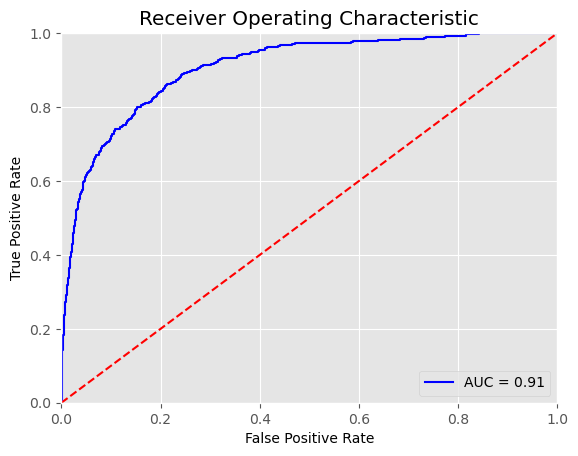

In [113]:
evaluate_model(cat, X_test, y_test, "none")
add_to_eval_df(cat, "CatBoostClassifier", "clean", X_train, y_train, X_test, y_test)

##### 2.2.1 LGBMClassifier

In [91]:
light = LGBMClassifier()
light.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1270, number of negative: 18084
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 19354, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.065620 -> initscore=-2.656011
[LightGBM] [Info] Start training from score -2.656011


LGBMClassifier()

none model accuracy for classification is = 94.88%
------------------------------------------------
Confusion Matrix:
      0    1
0  7687   67
1   358  183
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      7754
           1       0.73      0.34      0.46       541

    accuracy                           0.95      8295
   macro avg       0.84      0.66      0.72      8295
weighted avg       0.94      0.95      0.94      8295



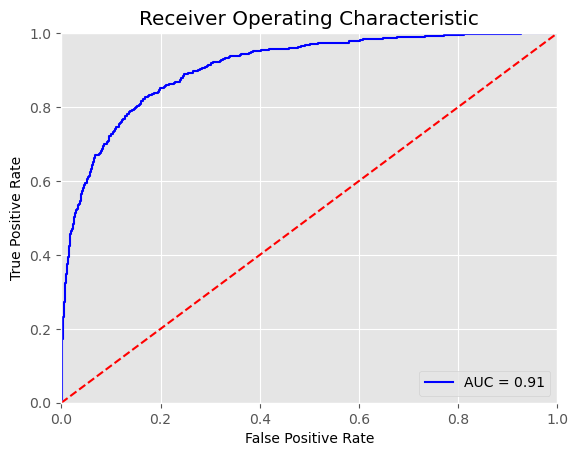

In [114]:
evaluate_model(light, X_test, y_test, "none")
add_to_eval_df(light, "LGBMClassifier", "clean", X_train, y_train, X_test, y_test)

#### 2.3 Stacking

##### 2.3.1 Stacking: RandomForest + LinearSVC

In [93]:
base_models = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('svc', LinearSVC(random_state=42))
]
stack = StackingClassifier(estimators=base_models, n_jobs=-1)

In [94]:
stack.fit(X_train, y_train)

StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('svc', LinearSVC(random_state=42))],
                   n_jobs=-1)

none model accuracy for classification is = 94.67%
------------------------------------------------
Confusion Matrix:
      0    1
0  7681   73
1   369  172
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7754
           1       0.70      0.32      0.44       541

    accuracy                           0.95      8295
   macro avg       0.83      0.65      0.70      8295
weighted avg       0.94      0.95      0.94      8295



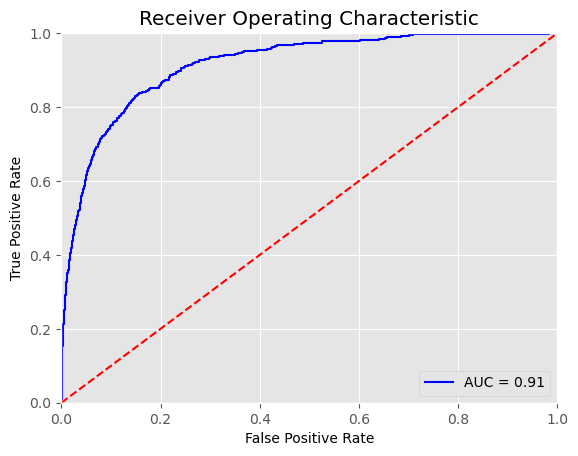

In [115]:
evaluate_model(stack, X_test, y_test, "none")
add_to_eval_df(stack, "StackingClassifier", "clean", X_train, y_train, X_test, y_test)

Vergleich: SVC

In [96]:
svc = LinearSVC()
svc.fit(X_train, y_train)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [116]:
evaluate_model(svc, X_test, y_test, "none")
add_to_eval_df(svc, "LinearSVC", "clean", X_train, y_train, X_test, y_test)

none model accuracy for classification is = 94.42%
------------------------------------------------
Confusion Matrix:
      0    1
0  7711   43
1   420  121
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7754
           1       0.74      0.22      0.34       541

    accuracy                           0.94      8295
   macro avg       0.84      0.61      0.66      8295
weighted avg       0.93      0.94      0.93      8295



AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

#### Model comparision

In [121]:
evaluation.sort_values(by=["test_prec"], ascending=False)

,model,variant,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
0,RandomForestClassifier,clean,0.999948,1.000000,0.999213,0.999606,0.943701,0.793651,0.184843,0.299850
1,RandomForestClassifier-tuned-rand,clean,0.943991,0.839416,0.181102,0.297927,0.941893,0.792079,0.147874,0.249221
2,RandomForest-tuned-optuna,clean,0.999897,1.000000,0.998425,0.999212,0.943701,0.772059,0.194085,0.310192
3,XGBClassifier-tuned-grid,clean,0.999948,1.000000,0.999213,0.999606,0.948523,0.733607,0.330869,0.456051
6,LGBMClassifier,clean,0.995763,0.995826,0.939370,0.966775,0.948764,0.732000,0.338262,0.462705
4,XGBClassifier-tuned-rand,clean,0.999173,0.999204,0.988189,0.993666,0.948885,0.725869,0.347505,0.470000
7,StackingClassifier,clean,0.969722,0.907143,0.600000,0.722275,0.946715,0.702041,0.317930,0.437659
8,XGBClassifier,clean,0.999948,1.000000,0.999213,0.999606,0.947438,0.690909,0.351201,0.465686
5,CatBoostClassifier,clean,0.954170,0.830743,0.378740,0.520281,0.944304,0.683721,0.271719,0.388889
9,BalancedRandomForestClassifier,clean,0.868916,0.333596,1.000000,0.500295,0.840506,0.259828,0.781885,0.390041


In [122]:
evaluation.sort_values(by=["test_rec"], ascending=False)

,model,variant,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
10,BalancedRandomForestClassifier-tuned,clean,0.826961,0.253615,0.842520,0.389871,0.822905,0.239033,0.785582,0.366537
9,BalancedRandomForestClassifier,clean,0.868916,0.333596,1.000000,0.500295,0.840506,0.259828,0.781885,0.390041
8,XGBClassifier,clean,0.999948,1.000000,0.999213,0.999606,0.947438,0.690909,0.351201,0.465686
4,XGBClassifier-tuned-rand,clean,0.999173,0.999204,0.988189,0.993666,0.948885,0.725869,0.347505,0.470000
6,LGBMClassifier,clean,0.995763,0.995826,0.939370,0.966775,0.948764,0.732000,0.338262,0.462705
3,XGBClassifier-tuned-grid,clean,0.999948,1.000000,0.999213,0.999606,0.948523,0.733607,0.330869,0.456051
7,StackingClassifier,clean,0.969722,0.907143,0.600000,0.722275,0.946715,0.702041,0.317930,0.437659
5,CatBoostClassifier,clean,0.954170,0.830743,0.378740,0.520281,0.944304,0.683721,0.271719,0.388889
2,RandomForest-tuned-optuna,clean,0.999897,1.000000,0.998425,0.999212,0.943701,0.772059,0.194085,0.310192
0,RandomForestClassifier,clean,0.999948,1.000000,0.999213,0.999606,0.943701,0.793651,0.184843,0.299850


In [123]:
evaluation.sort_values(by=["test_f1"], ascending=False)

,model,variant,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
4,XGBClassifier-tuned-rand,clean,0.999173,0.999204,0.988189,0.993666,0.948885,0.725869,0.347505,0.470000
8,XGBClassifier,clean,0.999948,1.000000,0.999213,0.999606,0.947438,0.690909,0.351201,0.465686
6,LGBMClassifier,clean,0.995763,0.995826,0.939370,0.966775,0.948764,0.732000,0.338262,0.462705
3,XGBClassifier-tuned-grid,clean,0.999948,1.000000,0.999213,0.999606,0.948523,0.733607,0.330869,0.456051
7,StackingClassifier,clean,0.969722,0.907143,0.600000,0.722275,0.946715,0.702041,0.317930,0.437659
9,BalancedRandomForestClassifier,clean,0.868916,0.333596,1.000000,0.500295,0.840506,0.259828,0.781885,0.390041
5,CatBoostClassifier,clean,0.954170,0.830743,0.378740,0.520281,0.944304,0.683721,0.271719,0.388889
10,BalancedRandomForestClassifier-tuned,clean,0.826961,0.253615,0.842520,0.389871,0.822905,0.239033,0.785582,0.366537
2,RandomForest-tuned-optuna,clean,0.999897,1.000000,0.998425,0.999212,0.943701,0.772059,0.194085,0.310192
0,RandomForestClassifier,clean,0.999948,1.000000,0.999213,0.999606,0.943701,0.793651,0.184843,0.299850


In [124]:
evaluation['vectorize_variant'] = "w2v"
evaluation = evaluation[['model',
 'variant',
 'vectorize_variant',
 'train_acc',
 'train_prec',
 'train_rec',
 'train_f1',
 'test_acc',
 'test_prec',
 'test_rec',
 'test_f1']]

outname = 'evaluation_w2v.csv'

outdir = './eval_data'
if not os.path.exists(outdir):
    os.mkdir(outdir)

fullname = os.path.join(outdir, outname)

evaluation.to_csv(fullname)